In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-21T02:09:14.176866+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn import preprocessing
from catboost import CatBoostRegressor, Pool, cv

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

cb_version: 0.24.3
sklearn_version: 0.24.2


In [5]:
%watermark --iversions

numpy     : 1.20.3
sklearn   : 0.24.2
pandas    : 0.25.3
seaborn   : 0.11.1
matplotlib: 3.3.4



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED  = 309487
XGB_RANDOMSEED = 56
LGB_RANDOMSEED = 874256

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [8]:
NTRY = 25
NAME = f'{NTRY}_cb_pca64_sber_bord_nose_iter_2mod'

In [9]:
VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Load data

In [10]:
df_train = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)


In [11]:
df_train.shape, df_test.shape, 

((6981, 292), (3000, 289))

In [12]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr']
['hour', 'dow', 'day', 'mounth', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


In [13]:
num_cols.extend(['hour', 'mounth'])
cat_cols.extend(['dow', 
                 'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', #'distrib_brdr',
                 #'spec_event_1',
                ])

In [14]:
for el in cat_cols:
    df_train[el] = df_train[el].astype(str)
    df_test[el] = df_test[el].astype(str)

In [15]:
#views
train_views_start = Pool(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                         df_train[df_train.distrib_brdr == 1][['views']],
                         cat_features = cat_cols,
                         #feature_names = cat_cols + num_cols
                        )
train_views_end = Pool(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                       df_train[df_train.distrib_brdr == 0][['views']],
                       cat_features = cat_cols,
                       #feature_names = cat_cols + num_cols
                      )
#depth
train_depth_start = Pool(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                         df_train[df_train.distrib_brdr == 1][['depth']],
                         cat_features = cat_cols,
                         #feature_names = cat_cols + num_cols
                        )
train_depth_end = Pool(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                       df_train[df_train.distrib_brdr == 0][['depth']],
                       cat_features = cat_cols,
                       #feature_names = cat_cols + num_cols
                      )

#frp
train_frp_start = Pool(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                       df_train[df_train.distrib_brdr == 1][['full_reads_percent']],
                       cat_features = cat_cols,
                       #feature_names = cat_cols + num_cols
                      )
train_frp_end = Pool(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                     df_train[df_train.distrib_brdr == 0][['full_reads_percent']],
                     cat_features = cat_cols,
                     #feature_names = cat_cols + num_cols
                    )

#full_reads_percent
#у frp корреляция с depth. так что добавим признак deprh_pred и соберем датасет уже после предсказания depth

In [16]:
def plot_feature_importance2(inp_model, inp_pool, imp_number = 30):
    
    data = pd.DataFrame({'feature_importance': inp_model.get_feature_importance(inp_pool), 
              'feature_names': inp_pool.get_feature_names()}).sort_values(by=['feature_importance'], 
                                                       ascending=True)
    
    data.nlargest(imp_number, columns="feature_importance").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [17]:
def plot_feature_importance(importance,names,model_type, imp_number = 30):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:imp_number], y=fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## views

In [18]:
cb_params_views = {"iterations": 2500,
                  #"depth": 2,
                  "loss_function": "RMSE",
                  'eval_metric': 'R2',
                  "verbose": False
                  }

In [19]:
def get_model(inp_pool, inp_params):
    
    
    scores = cv(inp_pool,
                      inp_params,
                      fold_count=5,
                      seed = CB_RANDOMSEED, 
                      #plot="True"
                     )
    
    #if scores['test-RMSE-mean'].argmin() != scores['test-R2-mean'].argmax():
    #    raise ValueError('wtf?', scores['test-RMSE-mean'].argmin(), scores['test-R2-mean'].argmax())
    
    print(scores[scores['test-R2-mean'] == scores['test-R2-mean'].max()].to_string())
    
    niters = scores['test-R2-mean'].argmax()
    print(niters)
    
    cb_model = CatBoostRegressor(iterations=niters,
                                 #learning_rate=0.05,
                                 #depth=10,
                                 random_seed = CB_RANDOMSEED,
                                 #n_estimators=100,
                                  )
    # Fit model
    cb_model.fit(inp_pool,
                      #plot = True,
                       verbose = 100,
                      )
    
    
    return cb_model

In [20]:
#scores_views

In [21]:
%%time
model_views_start = get_model(train_views_start, cb_params_views)

      iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
2410        2410      0.514488     0.085848       0.996769      0.000571    57288.439777   21396.965895      4719.273203      150.040884
2410
Learning rate set to 0.02457
0:	learn: 83167.4254994	total: 49.2ms	remaining: 1m 58s
100:	learn: 53574.6758291	total: 3.25s	remaining: 1m 14s
200:	learn: 43912.6562626	total: 6.55s	remaining: 1m 12s
300:	learn: 38721.1823427	total: 9.66s	remaining: 1m 7s
400:	learn: 34440.9100319	total: 12.9s	remaining: 1m 4s
500:	learn: 30710.4857723	total: 16s	remaining: 1m 1s
600:	learn: 27579.1810837	total: 19.1s	remaining: 57.5s
700:	learn: 25294.2672771	total: 22.2s	remaining: 54.1s
800:	learn: 23110.9294598	total: 25.3s	remaining: 50.8s
900:	learn: 21272.7214876	total: 28.4s	remaining: 47.6s
1000:	learn: 19575.0531380	total: 31.5s	remaining: 44.4s
1100:	learn: 18143.7007650	total: 34.6s	remaining: 41.2s
1200:	learn: 16852

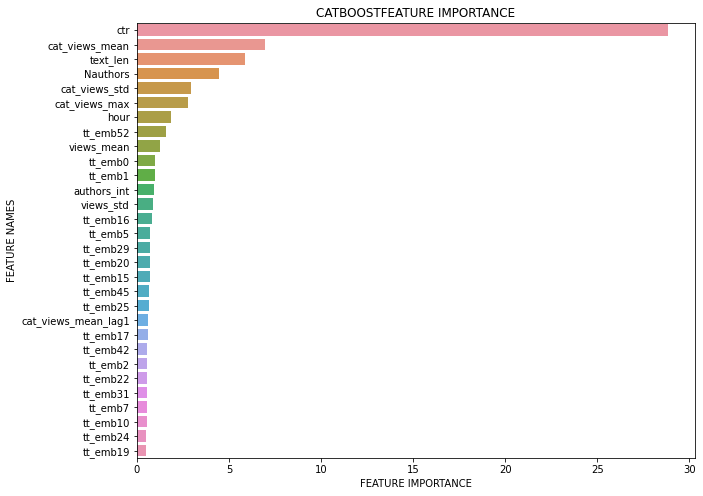

In [22]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_views_start.get_feature_importance(), train_views_start.get_feature_names(), 'CATBOOST')

In [23]:
%%time
model_views_end = get_model(train_views_end, cb_params_views)

     iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
670         670      0.608364     0.065935       0.914413      0.008288     9189.254018     910.007358      4340.903897      127.150327
670
Learning rate set to 0.067125
0:	learn: 14478.5711190	total: 34.7ms	remaining: 23.2s
100:	learn: 6862.2907587	total: 3.44s	remaining: 19.4s
200:	learn: 5484.1994170	total: 6.72s	remaining: 15.7s
300:	learn: 4671.9640377	total: 9.97s	remaining: 12.2s
400:	learn: 4034.0105430	total: 13.3s	remaining: 8.93s
500:	learn: 3491.6141249	total: 16.7s	remaining: 5.65s
600:	learn: 3068.8562329	total: 20.1s	remaining: 2.31s
669:	learn: 2824.6580921	total: 22.5s	remaining: 0us
Wall time: 57min 37s


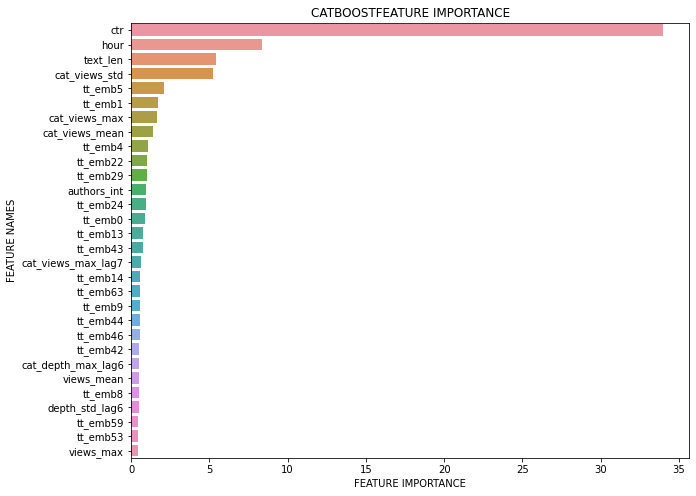

In [24]:
plot_feature_importance(model_views_end.get_feature_importance(), train_views_end.get_feature_names(), 'CATBOOST')

## depth

In [25]:
cb_params_depth = cb_params_views

In [26]:
%%time
model_depth_start = get_model(train_depth_start, cb_params_depth)

      iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
1550        1550      0.471369     0.152844        0.96694      0.002016         0.03689       0.003182         0.009499        0.000204
1550
Learning rate set to 0.034362
0:	learn: 0.0516106	total: 32.6ms	remaining: 50.6s
100:	learn: 0.0326142	total: 3.11s	remaining: 44.6s
200:	learn: 0.0294415	total: 6.25s	remaining: 41.9s
300:	learn: 0.0265716	total: 9.34s	remaining: 38.8s
400:	learn: 0.0239564	total: 12.5s	remaining: 35.7s
500:	learn: 0.0217852	total: 15.5s	remaining: 32.5s
600:	learn: 0.0199028	total: 18.6s	remaining: 29.4s
700:	learn: 0.0182410	total: 21.8s	remaining: 26.4s
800:	learn: 0.0166942	total: 24.9s	remaining: 23.3s
900:	learn: 0.0152275	total: 28s	remaining: 20.2s
1000:	learn: 0.0140455	total: 31.1s	remaining: 17s
1100:	learn: 0.0129136	total: 34.2s	remaining: 13.9s
1200:	learn: 0.0118360	total: 37.3s	remaining: 10.8s
1300:	learn: 0.01

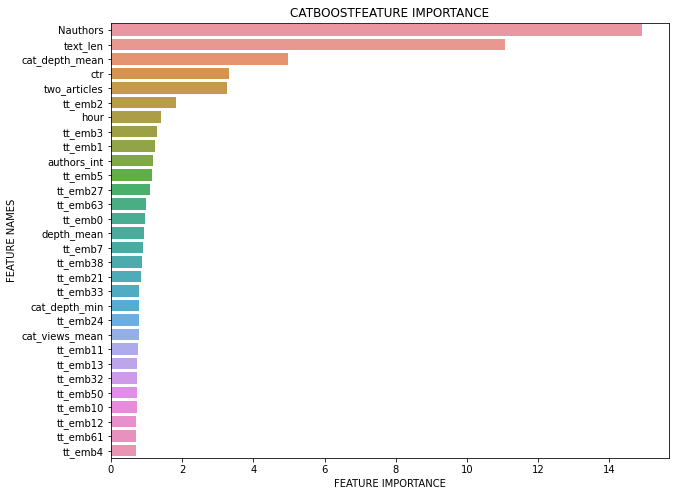

In [27]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_depth_start.get_feature_importance(), train_depth_start.get_feature_names(), 'CATBOOST')

In [28]:
%%time
model_depth_end = get_model(train_depth_end, cb_params_depth)

      iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
2483        2483      0.339217     0.083196       0.981393      0.001967        0.017239        0.00378         0.002936        0.000174
2483
Learning rate set to 0.024804
0:	learn: 0.0214397	total: 47.8ms	remaining: 1m 58s
100:	learn: 0.0165978	total: 3.63s	remaining: 1m 25s
200:	learn: 0.0145615	total: 7.29s	remaining: 1m 22s
300:	learn: 0.0131496	total: 10.7s	remaining: 1m 17s
400:	learn: 0.0121136	total: 14s	remaining: 1m 12s
500:	learn: 0.0112648	total: 17.5s	remaining: 1m 9s
600:	learn: 0.0105427	total: 20.9s	remaining: 1m 5s
700:	learn: 0.0099120	total: 24.2s	remaining: 1m 1s
800:	learn: 0.0093606	total: 27.6s	remaining: 57.9s
900:	learn: 0.0088588	total: 30.9s	remaining: 54.3s
1000:	learn: 0.0084016	total: 34.3s	remaining: 50.7s
1100:	learn: 0.0079686	total: 37.6s	remaining: 47.2s
1200:	learn: 0.0075794	total: 40.9s	remaining: 43.7s
1300:	lear

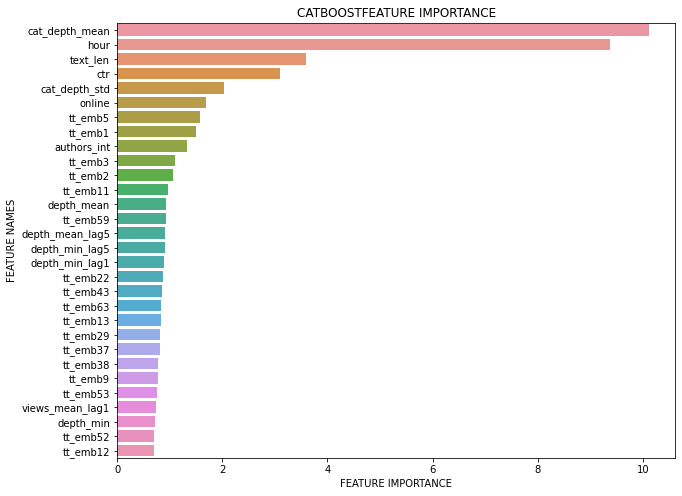

In [29]:
plot_feature_importance(model_depth_end.get_feature_importance(), train_depth_end.get_feature_names(), 'CATBOOST')

## full_reads_percent

In [30]:
cb_params_frp = cb_params_views

In [31]:
%%time
model_frp_start = get_model(train_frp_start, cb_params_frp)

      iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
1303        1303      0.556958     0.008903       0.948849      0.001106        7.007296       0.168132         2.382234         0.02588
1303
Learning rate set to 0.039208
0:	learn: 10.3673955	total: 29.7ms	remaining: 38.6s
100:	learn: 6.7908423	total: 3.14s	remaining: 37.4s
200:	learn: 6.1610766	total: 6.26s	remaining: 34.3s
300:	learn: 5.4955478	total: 9.31s	remaining: 31s
400:	learn: 4.8980374	total: 12.4s	remaining: 27.8s
500:	learn: 4.3891622	total: 15.5s	remaining: 24.8s
600:	learn: 3.9541427	total: 18.6s	remaining: 21.7s
700:	learn: 3.5901994	total: 21.8s	remaining: 18.7s
800:	learn: 3.2587022	total: 25.1s	remaining: 15.7s
900:	learn: 2.9752385	total: 28.4s	remaining: 12.7s
1000:	learn: 2.7187224	total: 31.5s	remaining: 9.5s
1100:	learn: 2.4837497	total: 34.6s	remaining: 6.34s
1200:	learn: 2.2674344	total: 37.7s	remaining: 3.2s
1300:	learn: 2.0

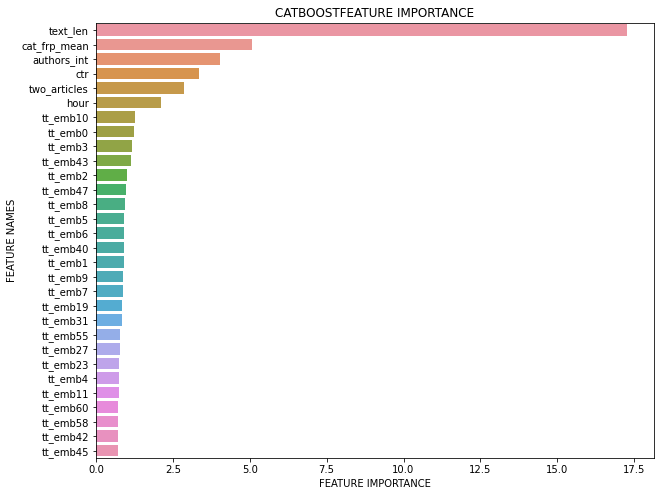

In [32]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_frp_start.get_feature_importance(), train_frp_start.get_feature_names(), 'CATBOOST')

In [33]:
%%time
model_frp_end = get_model(train_frp_end, cb_params_frp)

     iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
924         924      0.558665     0.027472       0.877142      0.002326        6.416195        0.07435         3.389853         0.04638
924
Learning rate set to 0.052577
0:	learn: 9.4666249	total: 35.1ms	remaining: 32.4s
100:	learn: 6.0839665	total: 3.34s	remaining: 27.2s
200:	learn: 5.4219900	total: 6.65s	remaining: 23.9s
300:	learn: 4.7696534	total: 10.1s	remaining: 20.8s
400:	learn: 4.2638598	total: 13.7s	remaining: 17.8s
500:	learn: 3.8016583	total: 17.1s	remaining: 14.5s
600:	learn: 3.4363623	total: 20.7s	remaining: 11.1s
700:	learn: 3.0979469	total: 24s	remaining: 7.64s
800:	learn: 2.7911929	total: 27.3s	remaining: 4.19s
900:	learn: 2.5048999	total: 30.6s	remaining: 781ms
923:	learn: 2.4462533	total: 31.4s	remaining: 0us
Wall time: 57min 5s


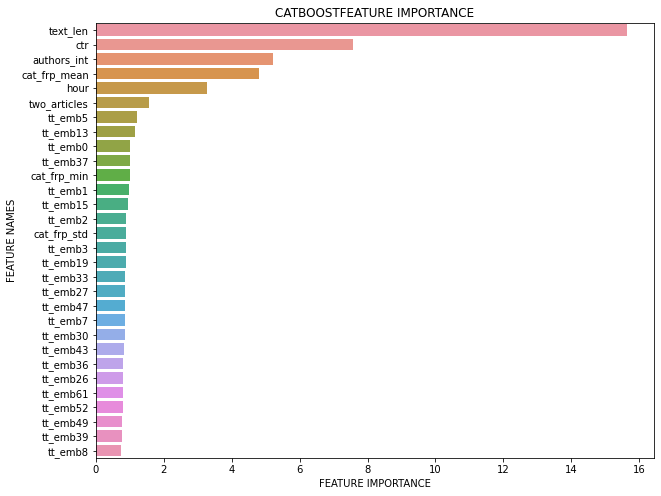

In [34]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_frp_end.get_feature_importance(), train_frp_end.get_feature_names(), 'CATBOOST')

## Сохраняем предсказания для ансамблей / стекинга

In [86]:
pred_train = pd.DataFrame()
pred_train[['document_id', 'distrib_brdr']] = df_train[['document_id', 'distrib_brdr']]
pred_train = pred_train.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [87]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'views'] = model_views_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'views'] = model_views_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
sum(pred_train.views.isna())

0

In [88]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'depth'] = model_depth_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'depth'] = model_depth_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
sum(pred_train.depth.isna())

0

In [89]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'full_reads_percent'] = model_frp_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'full_reads_percent'] = model_frp_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
sum(pred_train.full_reads_percent.isna())

0

In [90]:
pred_train.drop(['distrib_brdr'], axis =1, inplace = True)
pred_train.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_train_part.csv'), index = False)

## save models

In [35]:
#cb_model_views.save_model(os.path.join(DIR_MODELS, f'{NTRY}_pca64_cb_views.cbm'), 
model_views_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_v_start.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_views_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_v_end.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_depth_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_d_start.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_depth_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_d_end.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_frp_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_f_start.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_frp_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_f_end.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

## make predict

In [66]:
subm = pd.DataFrame()
subm[['document_id', 'distrib_brdr']] = df_test[['document_id', 'distrib_brdr']]
subm = subm.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [67]:
subm.loc[subm.query('distrib_brdr == 1').index, 'views'] = model_views_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'views'] = model_views_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.views.isna())

0

In [68]:
subm.loc[subm.query('distrib_brdr == 1').index, 'depth'] = model_depth_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'depth'] = model_depth_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.depth.isna())

0

In [69]:
subm.loc[subm.query('distrib_brdr == 1').index, 'full_reads_percent'] = model_frp_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'full_reads_percent'] = model_frp_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.full_reads_percent.isna())

0

In [70]:
subm.drop(['distrib_brdr'], axis = 1, inplace = True)

In [71]:
doc_id_ukr = df_test[df_test.spec == 1].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,154690.491916,1.129062,17.660287
1440,153627.211459,1.147872,24.085768
2645,149365.817511,1.162967,26.911664


In [72]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [73]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,14373.004863,1.204846,43.721250
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,5978.932869,1.058283,33.748877
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,8824.021815,1.057760,27.853561
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,7391.985447,1.063639,35.863349
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,117443.086763,1.143752,27.600877


In [74]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)